<a href="https://colab.research.google.com/github/nikhilv7/My_Wireless_Projects/blob/master/Unbalanced_LSAPComp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers
!pip3 install hungarian-algorithm
from hungarian_algorithm import algorithm
!pip install munkres
from munkres import Munkres, print_matrix
import matplotlib.pyplot as plt
from itertools import combinations 
!pip install pyyaml h5py
import os
import time

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
noSU = 4
noChannels = 4
prec = 10000
channelindices = np.arange(noChannels)
n = max(noSU,noChannels)
noTrainingExamples = 50000
trainDataIn = 10*np.random.randint(1,prec,[noTrainingExamples,noChannels,noSU])/prec
decisionOut = np.zeros([noTrainingExamples,noChannels,noSU])
lowestcost = np.zeros(noTrainingExamples)

DataSet Generation

In [4]:
def squarify(M,MODE):
    (T,a,b)=M.shape
    if a>b:
        padding=((0,0),(0,0),(0,a-b))
    else:
        padding=((0,0),(0,b-a),(0,0))
    if (MODE == 'maximum'):
      return np.pad(M,padding,mode=MODE)
    elif (MODE == 'zero'):
      return np.pad(M,padding,mode='constant',constant_values=0)
    if (MODE == 'minimum'):
      return np.pad(M,padding,mode=MODE)


In [5]:
def decisionGen(G):
  matrix = G.tolist()
  m = Munkres()
  indexes = m.compute(matrix)
  decision = np.zeros(G.shape)
  totalcost = 0
  for row, column in indexes:
    decision[row][column] = 1
    totalcost = totalcost + matrix[row][column]
  return decision,totalcost

In [7]:
def hillClimb(G):
  X = np.identity(min(noSU,noChannels))
  initState = np.take(X,np.random.permutation(X.shape[0]),axis=0,out=X)
  initCost = np.sum(G * initState)
  currState = initState
  currCost = initCost
  ctr = 0
  while (ctr < 1*noChannels):
    i,j = random.choices(np.arange(noChannels),k=2)
    currState[[j,i]]=currState[[i,j]]
    ctr = ctr + 1
    if (np.sum(currState*G))<currCost :
      currCost = np.sum(currState*G)
      ctr = 0
    else :
      currState[[j,i]]=currState[[i,j]]
  
  return currState, currCost

In [8]:
decidedCost = np.zeros(noTrainingExamples)
maxCost = np.zeros(noTrainingExamples)
hillCost = np.zeros(noTrainingExamples)
hilldec = np.zeros([noTrainingExamples,noChannels,noSU])
wdecisionOut = np.zeros([noTrainingExamples,noChannels,noSU])
percentagedev = np.zeros(noTrainingExamples)
tochill = time.time()
for idx in range(noTrainingExamples):
  decisionOut[idx,:,:],decidedCost[idx] = decisionGen(trainDataIn[idx,:,:])
  wdecisionOut[idx,:,:],_ = decisionGen(np.max(trainDataIn[idx,:,:])-trainDataIn[idx,:,:])
  maxCost[idx] = np.sum(wdecisionOut[idx,:,:]*trainDataIn[idx,:,:])

  hilldec[idx,:,:],hillCost[idx] = hillClimb(trainDataIn[idx,:,:])
  percentagedev[idx] = (100/(maxCost[idx]-decidedCost[idx])) * (hillCost[idx] - decidedCost[idx])
tichill = time.time()

In [9]:
avgdevhill = np.mean(percentagedev)
print(avgdevhill, (tichill-tochill)/noTrainingExamples)

17.988421524011173 0.0004264035940170288


CNN model for LSAP

In [10]:
#ORIGINAL
cnnLayers = {}
Model = {}
Logs = {}
inputs = keras.Input(shape=(noChannels,noSU,1),name='CostMatrix',dtype = tf.float32)

for i in range(noSU):
   
  cnnLayers['L'+str(i)] = layers.Conv2D(4,(1,1),kernel_initializer='random_normal',kernel_regularizer='l2', activation='relu')(inputs)
  cnnLayers['L'+str(i)] = layers.Conv2D(8,(1,1),kernel_initializer='glorot_uniform',kernel_regularizer='l2',activation='relu')(cnnLayers['L'+str(i)])
  cnnLayers['L'+str(i)] = layers.Flatten()(cnnLayers['L'+str(i)])
  cnnLayers['L'+str(i)] = layers.Dense(128,activation='relu',kernel_regularizer='l2',)(cnnLayers['L'+str(i)])
  cnnLayers['L'+str(i)] = layers.Dense(256,activation='relu',kernel_regularizer='l2',)(cnnLayers['L'+str(i)])
  cnnLayers['L'+str(i)] = layers.Dense(64,activation='relu',kernel_regularizer='l2',)(cnnLayers['L'+str(i)])
  cnnLayers['Out'+str(i)] = layers.Dense(noChannels,kernel_regularizer='l2',activation='softmax')(cnnLayers['L'+str(i)])
  
  Model['model'+ str(i)] = keras.Model(inputs,cnnLayers['Out'+str(i)],name ='cnn'+str(i))
  Model['model'+ str(i)].compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=0.0001),metrics= ['accuracy'])

locals().update(Model)



Epoch 313/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3503 - accuracy: 0.9522 - val_loss: 0.3818 - val_accuracy: 0.9355
Epoch 314/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3480 - accuracy: 0.9530 - val_loss: 0.3835 - val_accuracy: 0.9331
Epoch 315/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3506 - accuracy: 0.9527 - val_loss: 0.3805 - val_accuracy: 0.9356
Epoch 316/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3494 - accuracy: 0.9520 - val_loss: 0.3797 - val_accuracy: 0.9350
Epoch 317/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3511 - accuracy: 0.9515 - val_loss: 0.3798 - val_accuracy: 0.9343
Epoch 318/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3509 - accuracy: 0.9497 - val_loss: 0.3816 - val_accuracy: 0.9338
Epoch 319/500
40/40 [==============================] - 0s 6ms/step - loss: 0.3519 - accuracy: 0.9501 - val_loss: 0.3783 - val_accuracy: 0.9350

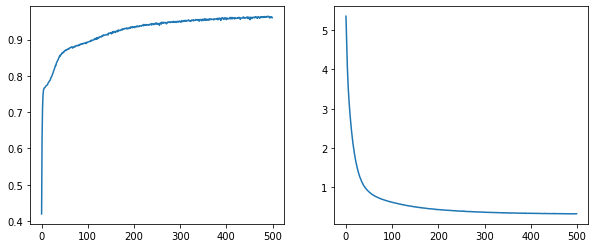

In [15]:
cnnLayers = {}
Model = {}
Logs = {}
inputs = keras.Input(shape=(noChannels,noSU,1),name='CostMatrix',dtype = tf.float32)

for i in range(noSU):
   
  cnnLayers['L'+str(i)] = layers.Conv2D(4,(1,1),kernel_initializer='random_normal',kernel_regularizer='l2', activation='relu')(inputs)
  cnnLayers['L'+str(i)] = layers.Conv2D(8,(1,1),kernel_initializer='glorot_uniform',kernel_regularizer='l2',activation='relu')(cnnLayers['L'+str(i)])
  cnnLayers['L'+str(i)] = layers.Flatten()(cnnLayers['L'+str(i)])
  cnnLayers['L'+str(i)] = layers.Dense(128,activation='relu',kernel_regularizer='l2',)(cnnLayers['L'+str(i)])
  cnnLayers['L'+str(i)] = layers.Dense(256,activation='relu',kernel_regularizer='l2',)(cnnLayers['L'+str(i)])
  cnnLayers['L'+str(i)] = layers.Dense(64,activation='relu',kernel_regularizer='l2',)(cnnLayers['L'+str(i)])
  cnnLayers['Out'+str(i)] = layers.Dense(noChannels,kernel_regularizer='l2',activation='softmax')(cnnLayers['L'+str(i)])
  
  Model['model'+ str(i)] = keras.Model(inputs,cnnLayers['Out'+str(i)],name ='cnn'+str(i))
  Model['model'+ str(i)].compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=0.0001),metrics= ['accuracy'])

locals().update(Model)

for j in range(noSU):
  Logs['log'+str(j)] = Model['model'+str(j)].fit(10*trainDataIn,decisionOut[:,:,j],epochs=500,batch_size=1024,verbose=1,validation_split=0.2)

locals().update(Logs)
fig,axes= plt.subplots(1,2,figsize=(10,4))
axes[0].plot(log1.history['accuracy'])
axes[1].plot(log1.history['loss'])

In [85]:
#6 & 8 & 16
cnnLayers = {}
Model = {}
Logs = {}
inputs = keras.Input(shape=(noChannels,noSU,1),name='CostMatrix',dtype = tf.float32)

for i in range(noSU):
   
  cnnLayers['L'+str(i)] = layers.Conv2D(10,(2,1),kernel_initializer='glorot_uniform',kernel_regularizer='l2', activation='relu')(inputs)
  cnnLayers['L'+str(i)] = layers.Conv2D(16,(1,2),kernel_initializer='glorot_uniform',kernel_regularizer='l2',activation='relu')(cnnLayers['L'+str(i)])
  cnnLayers['L'+str(i)] = layers.Conv2D(32,(2,1),kernel_initializer='glorot_uniform',kernel_regularizer='l2',activation='relu')(cnnLayers['L'+str(i)])
  cnnLayers['L'+str(i)] = layers.Flatten()(cnnLayers['L'+str(i)])
  cnnLayers['L'+str(i)] = layers.Dense(256,activation='relu',kernel_regularizer='l2',)(cnnLayers['L'+str(i)])
  cnnLayers['L'+str(i)] = layers.Dense(512,activation='relu',kernel_regularizer='l2',)(cnnLayers['L'+str(i)])
  cnnLayers['L'+str(i)] = layers.Dense(128,activation='relu',kernel_regularizer='l2',)(cnnLayers['L'+str(i)])
  cnnLayers['L'+str(i)] = layers.Dense(64,activation='relu',kernel_regularizer='l2',)(cnnLayers['L'+str(i)])
  cnnLayers['Out'+str(i)] = layers.Dense(noChannels,kernel_regularizer='l2',activation='softmax')(cnnLayers['L'+str(i)])
  
  Model['model'+ str(i)] = keras.Model(inputs,cnnLayers['Out'+str(i)],name ='cnn'+str(i))
  Model['model'+ str(i)].compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=0.001),metrics= ['accuracy'])

locals().update(Model)



In [ ]:
keras.utils.plot_model(model1,"my_first_model.png",show_shapes=1)

In [ ]:

for j in range(noSU):
  #j = 4
  checkpoint_path='/content/gdrive/My Drive/Research_/UnbalLSAPfeed4/t'+str(j)+'.ckpt'
  checkpoint_dir = os.path.dirname(checkpoint_path)
  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1, period= 50)
  Logs['log'+str(j)] = Model['model'+str(j)].fit(trainDataIn,decisionOut[:,:,j],epochs=500,callbacks=[cp_callback],
                                                batch_size=1024,verbose=1,validation_split=0.2)
  print("train \t"+ str(j) + "\t over")

locals().update(Logs)
for j in range(noSU):
  fig,axes= plt.subplots(1,2,figsize=(10,4))
  axes[0].plot(Logs['log'+str(j)].history['accuracy'])
  axes[1].plot(Logs['log'+str(j)].history['loss'])


In [11]:
for j in range(noSU):
  checkpoint_path='/content/gdrive/My Drive/Research_/UnbalLSAPfeed4/t'+str(j)+'.ckpt'
  Model["model"+str(j)].load_weights(checkpoint_path)

Test Data

In [16]:
testCount = 11111
testData = 100*np.random.randint(1,prec,[testCount,noChannels,noSU])/prec
decisionOutTest = np.zeros([testCount,noChannels,noSU])
predictTest = np.zeros([testCount,noChannels,noSU])
for idx in range(testCount):
  decisionOutTest[idx,:,:],_ = decisionGen(testData[idx,:,:])
  #predictTest[idx,:,:] = predictDecision(testData[idx,:,:])
for g in range(noChannels):
  Model["model"+str(g)].evaluate(testData,decisionOutTest[:,:,g])

348/348 [==============================] - 1s 2ms/step - loss: 0.3611 - accuracy: 0.9375


Collision Avoidance

In [17]:
def PredictionGeneration(G):
  predictt = collisionAvoid(G,predGen(G))
  return predictt,np.sum(G*predictt)


In [18]:
#G = np.random.randint(1,10,[noChannels,noSU])
def predGen(G):
  testD = np.zeros([1,noChannels,noSU,1])
  testD[0,:,:,0] = G
  pred = {}
  predict = []
  for k in range(noSU):
    pred["predict"+str(k)] = Model["model"+str(k)].predict(testD[:1,:,:,:])
    predict.append(pred["predict"+str(k)])
  predict = np.asarray(predict).reshape([noChannels,noSU]).T 
  predict_ = (predict/np.max(predict,axis=0))
  predict_[predict_<1]=0
  #print(predict_)
  return predict_
#print(G,"\n",predGen(G),"\n",decisionGen(G))

In [19]:
def collisionAvoid(G,predict_):
  jobmulti = np.where(np.sum(predict_,axis=1)>1)[0].tolist()
  jobunasign = np.where(np.sum(predict_,axis=1)<1)[0].tolist()
  if len(jobmulti)!=0:
    for t in jobmulti:
      cols = np.where(predict_[t,:]>0)[0].tolist()
      iddx = np.where(G[t,:]==np.min(G[t,cols]))[0].tolist()[0]
      predict_[t,:] = 0
      predict_[t,iddx]=1
    uncols = np.where(np.sum(predict_,axis=0)<1)[0].tolist()
    if len(uncols)==1:
      predict_[jobunasign[0],uncols[0]] =1
    else:
      P = np.random.randint(100,300,[noChannels,noSU])
      for k in jobunasign:
        P[k,uncols]=G[k,uncols]
      newPredict = collisionAvoid2(jobunasign,uncols,P)
      predict_ = predict_ + newPredict
  return predict_

In [20]:
def collisionAvoid2(jobunasign,uncols,P):
  newPred2 = predGen(P)
  subPred = np.zeros([noChannels,noSU])
  for k in jobunasign:
      subPred[k,uncols]=newPred2[k,uncols]
  multipleJobs = np.where(np.sum(subPred, axis=1)>1)[0].tolist()
  unassignedJobs = np.where(np.sum(subPred, axis=1)==0)[0].tolist()
  if len(multipleJobs)==0:
    return subPred
  else :
    for t in multipleJobs:
      cols = np.where(subPred[t,:]>0)[0].tolist()
      iddx = np.where(P[t,:]==np.min(P[t,cols]))[0].tolist()[0]
      subPred[t,:] = 0
      subPred[t,iddx]=1
    uncols2 = np.where(np.sum(subPred,axis=0)<1)[0].tolist()
    uncols2 = list(set(uncols).intersection(uncols2))
    unassignedJobs = list(set(unassignedJobs).intersection(jobunasign))
    P_ = np.random.randint(400,900,[noChannels,noSU])
    for k in unassignedJobs:
      P_[k,uncols2]=P[k,uncols2]
    newPredict = collisionAvoid2(unassignedJobs,uncols2,P_)
    return subPred +newPredict

In [ ]:
testCountlsap = 2000
testDatalsap = 100*np.random.randint(1,prec,[testCountlsap,noChannels,noSU])/prec
decidedCostlsap = np.zeros(testCountlsap)
maxCostlsap = np.zeros(testCountlsap)
lsapCost = np.zeros(testCountlsap)
lsapdec = np.zeros([testCountlsap,noChannels,noSU])
decisionOutTestlsap =  np.zeros([testCountlsap,noChannels,noSU])
wdecisionOutlsap = np.zeros([testCountlsap,noChannels,noSU])
percentagedevlsap = np.zeros(testCountlsap)
toclsap = time.time()
for idx in range(testCountlsap):
  if idx%500 ==0:
    print(idx)
  decisionOutTestlsap[idx,:,:],decidedCostlsap[idx] = decisionGen(testDatalsap[idx,:,:])
  wdecisionOutlsap[idx,:,:],_ = decisionGen(np.max(testDatalsap[idx,:,:])-testDatalsap[idx,:,:])
  maxCostlsap[idx] = np.sum(wdecisionOutlsap[idx,:,:]*testDatalsap[idx,:,:])
  lsapdec[idx,:,:],lsapCost[idx] = PredictionGeneration(testDatalsap[idx,:,:])
  #print(np.round(decidedCostlsap[idx],2),"\t\t\t",np.round(lsapCost[idx],2),"\n")
  percentagedevlsap[idx] = (100/(maxCostlsap[idx]-decidedCostlsap[idx])) * (lsapCost[idx] - decidedCostlsap[idx])
ticlsap = time.time()

0
500
1000
1500


In [20]:
avgdevlsap = np.mean(percentagedevlsap)
print(avgdevlsap,(ticlsap-toclsap)/testCountlsap)

2.9282723941928723 0.11986881113052368


In [ ]:
tic  = time.time()
for i in range(20000):
  a=1+2
toc = time.time()

In [ ]:
print(toclsap-ticlsap)

-4229.123147726059


In [ ]:
toc-tic

0.0030705928802490234

In [ ]:
def predictDecision(G):
  testD = np.zeros([1,noChannels,noSU,1])
  testD[0,:,:,0] = G
  pred = {}
  predict = []
  for k in range(noSU):
    pred["predict"+str(k)] = Model["model"+str(k)].predict(testD[:1,:,:,:])
    predict.append(pred["predict"+str(k)])
  predict = np.asarray(predict).reshape([noChannels,noSU]) 
  outdecision = decisionGen(testD[0,:,:,0])

  predict_ = (predict/np.max(predict,axis=1))
  predict_[predict_<1]=0
  if(np.linalg.det(predict_) == 0 ):
    jobmulti = np.where(np.sum(predict_,axis=1)>1)[0]
    jobunasign = np.where(np.sum(predict_,axis=1)<1)[0]
    costs = predict_*G
    rowmulti = costs[jobmulti,:]
    maxidx = np.argmax(rowmulti)
    predict_[jobmulti,maxidx]=0
    predict_[jobunasign,maxidx]=1
  return predict_.T, np.sum((predict_.T)*G)

In [ ]:
for jf in range(1000):
  G = 10*np.random.randint(1,prec,[noChannels,noSU])/prec
  if (np.linalg.det(predictDecision(G)) == 0 ):
    print(G,'\n\n',decisionGen(G),'\n\n', predictDecision(G),"\n\n",np.sum(predictDecision(G)*G))

In [ ]:
testCountlsap = 10
testDatalsap = 10*np.random.randint(1,prec,[testCountlsap,noChannels,noSU])/prec
decidedCostlsap = np.zeros(testCountlsap)
maxCostlsap = np.zeros(testCountlsap)
lsapCost = np.zeros(testCountlsap)
lsapdec = np.zeros([testCountlsap,noChannels,noSU])
decisionOutTestlsap =  np.zeros([testCountlsap,noChannels,noSU])
wdecisionOutlsap = np.zeros([testCountlsap,noChannels,noSU])
percentagedevlsap = np.zeros(testCountlsap)
for idx in range(testCountlsap):
  decisionOutTestlsap[idx,:,:],decidedCostlsap[idx] = decisionGen(testDatalsap[idx,:,:])
  wdecisionOutlsap[idx,:,:],_ = decisionGen(np.max(testDatalsap[idx,:,:])-testDatalsap[idx,:,:])
  maxCostlsap[idx] = np.sum(wdecisionOutlsap[idx,:,:]*testDatalsap[idx,:,:])
  lsapdec[idx,:,:],lsapCost[idx] = predictDecision(testDatalsap[idx,:,:])
  #print(np.round(decidedCostlsap[idx],2),"\t\t\t",np.round(lsapCost[idx],2),"\n")
  percentagedevlsap[idx] = (100/(maxCostlsap[idx]-decidedCostlsap[idx])) * (lsapCost[idx] - decidedCostlsap[idx])

IndexError: ignored

In [ ]:
#G = GG
#G = Gh
#G = np.random.randint(1,10,[noChannels,noSU])
print(G)
testD = np.zeros([1,noChannels,noSU,1])
testD[0,:,:,0] = G
pred = {}
predict = []
for k in range(noSU):
  pred["predict"+str(k)] = Model["model"+str(k)].predict(testD[:1,:,:,:])
  predict.append(pred["predict"+str(k)])
  #print(predict,"\n")
predict = np.asarray(predict).reshape([noChannels,noSU]).T 
#print(predict)
#print(np.max(predict,axis=0))
predict_ = (predict/np.max(predict,axis=0))
predict_[predict_<1]=0
print(predict_,'\n')
jobmulti = np.where(np.sum(predict_,axis=1)>1)[0].tolist()
jobunasign = np.where(np.sum(predict_,axis=1)<1)[0].tolist()
for t in jobmulti:
  cols = np.where(predict_[t,:]>0)[0].tolist()
  iddx = np.where(G[t,:]==np.min(G[t,cols]))[0].tolist()[0]
  print(iddx)
  
  #print(t,cols,iddx)
  predict_[t,:] = 0
  predict_[t,iddx]=1

uncol = np.where(np.sum(predict_,axis=0)<1)[0].tolist()
P = np.random.randint(50,150,[noChannels,noSU])
for k in jobunasign:
  P[k,uncol]=G[k,uncol]
print(predict_)


print("\n\n\n\n\n\n\n")
'''

if(np.linalg.det(predict_) == 0):
  jobmulti = np.where(np.sum(predict_,axis=1)>1)[0]
  print(jobmulti)
  jobunasign = np.where(np.sum(predict_,axis=1)<1)[0]
  print(jobunasign)
  costs = predict_*G
  rowmulti = costs[jobmulti,:]
  print(rowmulti)
  maxidx = np.argmax(rowmulti)
  print(maxidx)
  predict_[jobmulti,maxidx]=0
  predict_[jobunasign,maxidx]=1
print(predict_.T, np.sum((predict_)*G))

print(predictDecision(G))
'''

In [ ]:
#OLD

def predictDecision(G):
  global count
  #count =noChannels
  testD = np.zeros([1,noChannels,noSU,1])
  testD[0,:,:,0] = G
  pred = {}
  predict = []
  for k in range(noSU):
    pred["predict"+str(k)] = Model["model"+str(k)].predict(testD[:1,:,:,:])
    predict.append(pred["predict"+str(k)])
  predict = np.asarray(predict).reshape([noChannels,noSU]).T
  predict_ = (predict/np.max(predict,axis=0))
  predict_[predict_<1]=0
  jobmulti = np.where(np.sum(predict_,axis=1)>1)[0].tolist()
  jobunasign = np.where(np.sum(predict_,axis=1)<1)[0].tolist()
  if len(jobmulti)<1 :
    print("no",predict_,"\n")
    return predict_ , np.sum(predict_*G)
  else :
    for t in jobmulti:
      cols = np.where(predict_[t,:]>0)[0].tolist()
      iddx = np.where(G[t,:]==np.min(G[t,cols]))[0].tolist()[0]
      predict_[t,:] = 0
      predict_[t,iddx]=1
    uncol = np.where(np.sum(predict_,axis=0)<1)[0].tolist()
    P = np.random.randint(250,10000,[noChannels,noSU])
    for k in jobunasign:
      P[k,uncol]=G[k,uncol]
    newPred,_ = predictDecision(P)
    for k in jobunasign:
      predict_[k,uncol]=newPred[k,uncol]
    print("yes",predict_,"\n")
    return predict_ , np.sum(predict_*G)


In [21]:
count = 0
for d in range(2000):
  G = 10*np.random.randint(1,prec,[noChannels,noSU])/prec
  ppp ,_ = PredictionGeneration(G)
  print(np.linalg.det(ppp))
  if np.linalg.det(ppp)==0:
    H = G
    break
  else:
    count = count+1

1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0
-1.0
1.0

In [ ]:
PredictionGeneration(G)

(array([[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.]]), 13.695)

In [ ]:
print(G,"\n",decisionGen(G))

[[3.711 6.867 1.981 1.823 5.006 1.842]
 [7.353 3.318 7.653 9.018 0.666 5.859]
 [8.95  7.65  9.144 0.067 3.398 9.125]
 [8.659 7.774 5.399 1.816 7.379 7.524]
 [2.895 7.525 6.008 9.486 4.639 5.548]
 [1.543 6.344 0.451 3.379 5.1   9.625]] 
 (array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]]), 13.695)


In [ ]:
predict_ = predGen(G)
predict_

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
print(predict_)
jobmulti = np.where(np.sum(predict_,axis=1)>1)[0].tolist()
print(jobmulti)
jobunasign = np.where(np.sum(predict_,axis=1)<1)[0].tolist()
print(jobunasign)
if len(jobmulti)==0:
  print("CAIF",predict_)
  #return predict_
else:
  for t in jobmulti:
    cols = np.where(predict_[t,:]>0)[0].tolist()
    iddx = np.where(G[t,:]==np.min(G[t,cols]))[0].tolist()[0]
    predict_[t,:] = 0
    predict_[t,iddx]=1
  print(predict_)
  uncols = np.where(np.sum(predict_,axis=0)<1)[0].tolist()
  print(uncols)
  P = np.random.randint(100,300,[noChannels,noSU])
  for k in jobunasign:
      P[k,uncols]=G[k,uncols]
  newPredict = collisionAvoid2(jobunasign,uncols,P)
  print(newPredict)
  predict_ = predict_ + newPredict
  print(predict_)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[2, 3]
[0, 5]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[1, 4]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [ ]:
print(P,predGen(P))

[[277   4 246 227   3 228]
 [132 101 232 199 252 278]
 [268 232 291 201 132 158]
 [116 136 249 266 119 191]
 [137 195 193 251 226 214]
 [111   2 274 292   9 240]] [[0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [ ]:
newPred2 = predGen(P)
print(newPred2)
subPred = np.zeros([noChannels,noSU])
for k in jobunasign:
  subPred[k,uncols]=newPred2[k,uncols]
print(subPred)
multipleJobs = np.where(np.sum(subPred, axis=1)>1)[0].tolist()
print(multipleJobs)
unassignedJobs = np.where(np.sum(subPred, axis=1)==0)[0].tolist()
print(unassignedJobs)

[[0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[0]
[1, 2, 3, 4, 5]


In [ ]:
for t in multipleJobs:
  cols = np.where(subPred[t,:]>0)[0].tolist()
  iddx = np.where(P[t,:]==np.min(P[t,cols]))[0].tolist()[0]
  subPred[t,:] = 0
  subPred[t,iddx]=1
print(subPred)
uncols2 = np.where(np.sum(subPred,axis=0)<1)[0].tolist()
uncols2 = list(set(uncols).intersection(uncols2))
print(uncols2)
unassignedJobs = list(set(unassignedJobs).intersection(jobunasign))
print(unassignedJobs)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[1]
[5]


In [ ]:
P_ = np.random.randint(400,900,[noChannels,noSU])
for k in unassignedJobs:
  P_[k,uncols2]=P[k,uncols2]

In [ ]:
collisionAvoid2(unassignedJobs,uncols2,P_)

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [ ]:
predict_

array([[0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.]])

In [ ]:
newPredict

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.]])

In [ ]:
  for t in jobmulti:
    cols = np.where(predict_[t,:]>0)[0].tolist()
    print(cols)
    iddx = np.where(G[t,:]==np.min(G[t,cols]))[0].tolist()[0]
    print(iddx)
    predict_[t,:] = 0
    predict_[t,iddx]=1
    print(predict_)

[0]
0
[[0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[2]
2
[[0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [ ]:
P

array([[279, 210, 295, 151],
       [208, 113, 177, 281],
       [286, 289, 297, 126],
       [  6, 226, 226, 140]])

In [ ]:
def predictDecision(G):
  global count
  #count =noChannels
  testD = np.zeros([1,noChannels,noSU,1])
  testD[0,:,:,0] = G
  pred = {}
  predict = []
  for k in range(noSU):
    pred["predict"+str(k)] = Model["model"+str(k)].predict(testD[:1,:,:,:])
    predict.append(pred["predict"+str(k)])
  predict = np.asarray(predict).reshape([noChannels,noSU]).T
  predict_ = (predict/np.max(predict,axis=0))
  predict_[predict_<1]=0
  jobmulti = np.where(np.sum(predict_,axis=1)>1)[0].tolist()
  print(len(jobmulti))
  jobunasign = np.where(np.sum(predict_,axis=1)<1)[0].tolist()
  if len(jobmulti)<2 :
    print("no",predict_,"\n")
    return predict_ , np.sum(predict_*G)
  else :
    for t in jobmulti:
      cols = np.where(predict_[t,:]>0)[0].tolist()
      iddx = np.where(G[t,:]==np.min(G[t,cols]))[0].tolist()[0]
      predict_[t,:] = 0
      predict_[t,iddx]=1
    uncol = np.where(np.sum(predict_,axis=0)<1)[0].tolist()
    P = np.random.randint(10,30,[noChannels,noSU])
    for k in jobunasign:
      P[k,uncol]=G[k,uncol]
    newPred,_ = predictDecision(P)
    for k in jobunasign:
      predict_[k,uncol]=newPred[k,uncol]
    print("yes",predict_,"\n")
    return predict_ , np.sum(predict_*G)


In [ ]:
print(P)
testD = np.zeros([1,noChannels,noSU,1])
testD[0,:,:,0] = P
pred = {}
predict = []
for k in range(noSU):
  pred["predict"+str(k)] = Model["model"+str(k)].predict(testD[:1,:,:,:])
  predict.append(pred["predict"+str(k)])
  #print(predict,"\n")
predict = np.asarray(predict).reshape([noChannels,noSU]).T 
#print(predict)
#print(np.max(predict,axis=0))
predict_ = (predict/np.max(predict,axis=0))
predict_[predict_<1]=0
print(np.round(predict_,2),decisionGen(testD[0,:,:,0]))
jobmulti = np.where(np.sum(predict_,axis=1)>1)[0].tolist()
jobunasign = np.where(np.sum(predict_,axis=1)<1)[0].tolist()
for t in jobmulti:
  cols = np.where(predict_[t,:]>0)[0].tolist()
  iddx = np.where(P[t,:]==np.min(P[t,cols]))[0].tolist()[0]
  print(iddx)
  
  #print(t,cols,iddx)
  predict_[t,:] = 0
  predict_[t,iddx]=1


[[969 653 736 771 631 736 503 530]
 [725 626 659 525 623 961 763 737]
 [669   2 510   7 769   9   8 997]
 [824 608 713 838 937 577 917 669]
 [805   7 542   8 933   7   6 956]
 [735 863 761 854 915 807 561 814]
 [601   2 614   6 620   7   4 753]
 [729   1 865   1 702   4   3 896]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 1. 1. 0.]] (array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]]), 2615.0)
4
1


In [ ]:
def predictDecision(G):
  global count
  count =20
  testD = np.zeros([1,noChannels,noSU,1])
  testD[0,:,:,0] = G
  pred = {}
  predict = []
  for k in range(noSU):
    pred["predict"+str(k)] = Model["model"+str(k)].predict(testD[:1,:,:,:])
    predict.append(pred["predict"+str(k)])
  predict = np.asarray(predict).reshape([noChannels,noSU]).T
  predict_ = (predict/np.max(predict,axis=0))
  predict_[predict_<1]=0
  jobmulti = np.where(np.sum(predict_,axis=1)>1)[0].tolist()
  jobunasign = np.where(np.sum(predict_,axis=1)<1)[0].tolist()
  if len(jobmulti)<1 and (count!=0):
    return predict_ , np.sum(predict_*G)
  elif (count!=0):
    for t in jobmulti:
      cols = np.where(predict_[t,:]>0)[0].tolist()
      iddx = np.where(G[t,:]==np.min(G[t,cols]))[0].tolist()[0]
      predict_[t,:] = 0
      predict_[t,iddx]=1
    uncol = np.where(np.sum(predict_,axis=0)<1)[0].tolist()
    P = np.full([noChannels,noSU],2*np.max(G))
    for k in jobunasign:
      P[k,uncol]=G[k,uncol]
    newPred,_ = predictDecision(P)
    for k in jobunasign:
      predict_[k,uncol]=newPred[k,uncol]
    count = count - 1
    print(count)
    return predict_ , np.sum(predict_*G)
  else :
    return predictDecision(10*np.random.randint(1,prec,[testCountlsap,noChannels,noSU])/prec)

In [ ]:
P = np.full([noChannels,noSU],np.inf)
for k in jobunasign:
  P[k,uncol]=G[k,uncol]

In [ ]:
predP

array([[inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf],
       [ 8., inf, inf, inf,  9.],
       [ 9., inf, inf, inf,  4.]])

In [ ]:
H

array([[inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf]])

In [ ]:
truCost = 10*np.random.randint(1,prec,[noChannels,noSU])/prec
initCost = np.zeros([noChannels,noSU])
newCost = initCost

In [ ]:
initCost = np.zeros([noChannels,noSU])
newCost = initCost
itr=10
while (itr!=0):
  decision = predictDecision(newCost)
  mask = np.ones([noChannels,noSU])- decision
  noisyCost = np.zeros([noChannels,noSU])
  print(np.round(newCost,2),"\n\n--Iteration-- \n\n", decision)
  for itt in range(100):
    temp = truCost + np.random.normal(0,2,[noChannels,noSU])
    noisyCost = temp + noisyCost
  noisyCost = noisyCost/100
  newCost = decision*noisyCost + mask*newCost
  itr = itr-1
print(np.round(truCost,2),'\n\n',np.round(newCost,2),'\n\n')
print(decisionGen(truCost),'\n\n',decisionGen(newCost),'\n\n')
print(predictDecision(truCost),'\n\n',predictDecision(newCost),'\n\n')

In [ ]:
allcomb = []
for r in range(noChannels):
  for comb in combinations(channelindices,r):
    allcomb.append(comb)
print(H,"\n\n",outdecision,'\n\n',np.round(predict,2).T,'\n\n',predict_.T,np.sum(predict_*H))

[[95 43 72 24 55]
 [ 9  5 76 47 13]
 [50 26 69 25 57]
 [30 14 66 66 14]
 [26 89 30 53 45]] 

 (array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]]), 103.0) 

 [[0.   0.04 0.   0.97 0.01]
 [0.9  0.21 0.   0.   0.1 ]
 [0.01 0.23 0.   0.03 0.  ]
 [0.06 0.52 0.   0.   0.9 ]
 [0.03 0.   1.   0.   0.  ]] 

 [[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]] 259.0


In [ ]:
testCount = 11111
testData = 10*np.random.randint(1,prec,[testCount,noChannels,noSU])/prec
decisionOutTest = np.zeros([testCount,noChannels,noSU])
predictTest = np.zeros([testCount,noChannels,noSU])
for idx in range(testCount):
  decisionOutTest[idx,:,:],_ = decisionGen(testData[idx,:,:])
  #predictTest[idx,:,:] = predictDecision(testData[idx,:,:])
for g in range(noChannels):
  Model["model"+str(g)].evaluate(testData,decisionOutTest[:,:,g])

348/348 [==============================] - 1s 2ms/step - loss: 0.5446 - accuracy: 0.8710
